<a href="https://colab.research.google.com/github/SidWorks01/MusicRnC/blob/main/MusicRnC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
!pip install scikeras[tensorflow]

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import librosa
import librosa.display
import numpy as np
import os
import pandas
import matplotlib.pyplot 
import IPython.display
import json
import math

## Signal Processing and Converting audio files to MFCC features

Load Audio files through librosa and get signal ( numpy array of amplitude +1 to -1) and sample rate ( sampling frequency )

Waveform ( Amplitude vs Time ) / Time Domain Dependency ---> Fast Fourier Transform ( Amplitude vs Frequency ) / Frequency Domain Dependency OR Spectogram by Short time Fourier Transform ( log Amplitude vs Time vs frequency ) ---> Extracting using MFCC features

In [ ]:
#attaching dataset files
DATASET_PATH = "/content/gdrive/MyDrive/Music_Genres/genres_original"
JSON_PATH = "data.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

Defining a function that iterates through all the audio files and extracts MFCC features by the above process

In [ ]:
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e. sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		# load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    # list of each segment, where each segment is numpy 2d array of (number of frames, number of MFCC coefficients)
                    mfcc = mfcc.T
                    # transpose of array (number of MFCC coefficients,number of frames)
                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
     


In [ ]:
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

Streaming output truncated to the last 5000 lines.
/content/gdrive/MyDrive/Music_Genres/genres_original/disco/disco.00086.wav, segment:10

Processing: blues
/content/gdrive/MyDrive/Music_Genres/genres_original/blues/blues.00011.wav, segment:1
/content/gdrive/MyDrive/Music_Genres/genres_original/blues/blues.00011.wav, segment:2
/content/gdrive/MyDrive/Music_Genres/genres_original/blues/blues.00011.wav, segment:3
/content/gdrive/MyDrive/Music_Genres/genres_original/blues/blues.00011.wav, segment:4
/content/gdrive/MyDrive/Music_Genres/genres_original/blues/blues.00011.wav, segment:5
/content/gdrive/MyDrive/Music_Genres/genres_original/blues/blues.00011.wav, segment:6
/content/gdrive/MyDrive/Music_Genres/genres_original/blues/blues.00011.wav, segment:7
/content/gdrive/MyDrive/Music_Genres/genres_original/blues/blues.00011.wav, segment:8
/content/gdrive/MyDrive/Music_Genres/genres_original/blues/blues.00011.wav, segment:9
/content/gdrive/MyDrive/Music_Genres/genres_original/blues/blues.0001

## Loading Data and Splitting it

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

import matplotlib.pyplot as plt
import random

import librosa
import math

In [ ]:
DATA_PATH = "/content/data.json"

In [ ]:
def load_data(data_path):

    with open(data_path, "r") as f:
        data = json.load(f)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y

In [ ]:
X, y = load_data(DATA_PATH)

Data succesfully loaded!


In [ ]:
X.shape

(9986, 130, 13)

In [ ]:
y.shape

(9986,)

In [ ]:
# create train, validation and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

# add an axis to input sets
X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
X_train.shape

(5991, 130, 13, 1)

In [ ]:
y_train.shape

(5991,)

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [ ]:
input_shape

(130, 13, 1)

## Building a CNN Model

In [ ]:
from tensorflow.keras import layers, models , regularizers
# build the CNN
model_cnn = keras.Sequential()

# 1st conv layer
model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.01), input_shape=input_shape))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
model_cnn.add(keras.layers.Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
model_cnn.add(keras.layers.Conv2D(32, (2, 2),kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model_cnn.add(keras.layers.Dropout(0.3))

# output layer
model_cnn.add(keras.layers.Dense(10, activation='softmax'))

### Compile Model with optimizer

In [ ]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 6, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 6, 32)        128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 2, 32)        0         
 2D)                                                             
                                                      

Tried to Regularize the Model and Prevent Overfitting by:

1.  **Batch Normalization**
```
z = (x - mean) / sqrt(variance + epsilon) * gamma + beta
```
where z is the final value of the x at any position and mean and variance is of the whole batch.
This Normalizes the Activations in each Channel using its Mean and Variance in each mini batch. This can Regularize the Model.

2.   **DropOut**
  
  Dropout randomly drops out some of the neurons in the network by setting their activations to zero with a given probability. Therefore preventing it to rely on one feature and improves generalization and solves overfitting.
  Here we used 0.3 i.e 30% drop rate. We can play around with this rate to reach an optimal value where neither the effects are extreme.


*In the above Model to regularize the data we used Batch Normalization after each CONV layer and after the training is done on flattened layer we used Dropout layer to make sure the features extracted ( an normalized ) are not overly relying on each other.*


3. **Early Stopping** : The validation dataset is typically a separate subset of the training data that is not used for training but is used to evaluate the model's performance during training. The model is trained on the training dataset and evaluated on the validation dataset at the end of each training epoch. If the performance on the validation dataset does not improve over a certain number of epochs, the training process is stopped, and the model parameters at the point of the best performance on the validation set are used as the final model. This helps to Increase Efficiency and prevent Overfitting.

4. **Weight Decay**:


*   L1: For Sparse Solutions. Adds up absolute value of kernel values in the loss functions.
       Not appropriate in this case as our data is close to 1 and less than 1.
*   L2: For Making sure the kernel values are Small. Adds up sqaure of kernel values in the loss functions. We tried it out however , it didnt make much of difference in the validation accuracy.




Normal Processing without Early Stopping


## Training

In [ ]:
# train model
history = model_cnn.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=50)

### Processing with Early Stopping

In [ ]:
  from tensorflow.keras.callbacks import EarlyStopping
  # Define early stopping callback
  early_stop = EarlyStopping(monitor='val_loss', patience=10)

  # Train the model with early stopping
  history = model_cnn.fit(X_train, y_train, 
                      epochs=100, batch_size=32, 
                      validation_data=(X_validation, y_validation),
                      callbacks=[early_stop])

Epoch 1/100
188/188 [==============================] - 17s 80ms/step - loss: 4.1858 - accuracy: 0.2250 - val_loss: 3.5899 - val_accuracy: 0.3531
Epoch 2/100
188/188 [==============================] - 15s 78ms/step - loss: 3.5601 - accuracy: 0.3522 - val_loss: 3.2638 - val_accuracy: 0.4372
Epoch 3/100
188/188 [==============================] - 15s 78ms/step - loss: 3.3075 - accuracy: 0.4160 - val_loss: 3.0960 - val_accuracy: 0.4686
Epoch 4/100
188/188 [==============================] - 15s 80ms/step - loss: 3.1454 - accuracy: 0.4440 - val_loss: 2.9542 - val_accuracy: 0.5060
Epoch 5/100
188/188 [==============================] - 15s 80ms/step - loss: 2.9969 - accuracy: 0.4760 - val_loss: 2.8444 - val_accuracy: 0.5267
Epoch 6/100
188/188 [==============================] - 15s 80ms/step - loss: 2.8745 - accuracy: 0.4989 - val_loss: 2.7333 - val_accuracy: 0.5414
Epoch 7/100
188/188 [==============================] - 15s 80ms/step - loss: 2.7610 - accuracy: 0.5206 - val_loss: 2.6523 - val_ac

An Accuracy of 93% is reached without ensembler technique on the validation Data.

In [ ]:
test_loss, test_acc = model_cnn.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

79/79 - 1s - loss: 1.2195 - accuracy: 0.7689 - 731ms/epoch - 9ms/step

Test accuracy: 0.7689226865768433


And Test Accuracy is 76.9%

In [ ]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.show()

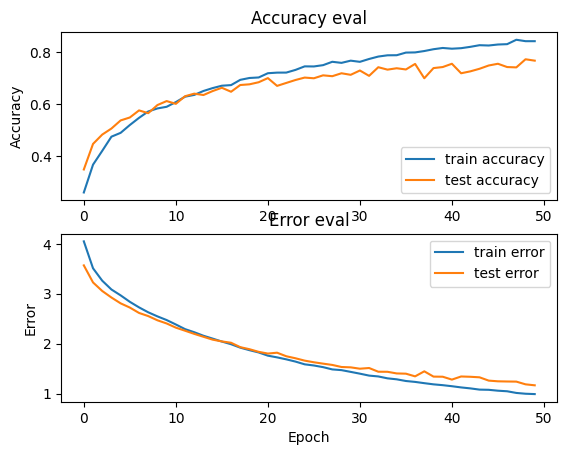

In [ ]:
plot_history(history)

Let's Try Implementing Voting Ensembler and GridCVSearch for HyperParameters tuning and Searching Accuarate optimizers

## Ensembler

In [ ]:
from tensorflow.keras import layers, models , regularizers
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from scikeras.wrappers import KerasClassifier
import tensorflow
# Define the function that creates the model
def create_model(num_layers=3, num_neurons=32, optimizer='adam', dropout_rate=0.3, learning_rate=0.001):
    model = models.Sequential()
    for i in range(num_layers):
        model.add(layers.Conv2D(num_neurons, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.01), input_shape=input_shape,padding='same'))
        model.add(layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
        model.add(layers.BatchNormalization())
        if i>1:
          model.add(layers.Conv2D(num_neurons, (2,2), activation='relu',kernel_regularizer=regularizers.l2(0.01), input_shape=input_shape,padding='same'))
          model.add(layers.MaxPooling2D((2,2), strides=(2, 2), padding='same'))
          model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(10, activation='softmax'))

    if optimizer == 'adam':
        opt = tensorflow.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        opt = tensorflow.keras.optimizers.SGD(learning_rate=learning_rate)
        
    # Compile the model
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
# Wrap the Keras model in a scikit-learn classifier
model = KerasClassifier(model=create_model, epochs=100, batch_size=32, verbose=0, num_layers=3, num_neurons=32, optimizer='adam', dropout_rate=0.3, learning_rate=0.001)


In [ ]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'num_layers': [3],
    'num_neurons': [32,64],
    'optimizer': ['adam','SGD'],
    'dropout_rate': [0.25,0.3,0.4],
    'learning_rate': [0.001, 0.01]
}

# Create the voting classifier with the GridSearchCV models
voting_clf = VotingClassifier(
    estimators=[
        ('adam', GridSearchCV(model, param_grid=param_grid, cv=2, n_jobs=-1, verbose=1)),
        ('sgd', GridSearchCV(model, param_grid=param_grid, cv=2, n_jobs=-1, verbose=1))
    ],
    voting='soft'
)

In [ ]:
# Fit the voting classifier on the training data
voting_clf.fit(X_train, y_train)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 2 folds for each of 24 candidates, totalling 48 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


VotingClassifier(estimators=[('adam',
                              GridSearchCV(cv=2,
                                           estimator=KerasClassifier(batch_size=32, dropout_rate=0.3, epochs=100, learning_rate=0.001, model=<function create_model at 0x7fe38ab68820>, num_layers=3, num_neurons=32, optimizer='adam', verbose=0),
                                           n_jobs=-1,
                                           param_grid={'dropout_rate': [0.25,
                                                                        0.3,
                                                                        0.4],
                                                       'learning_rate': [0.001,
                                                                         0.01],
                                                       'num_layers': [3],
                                                       'num_neu...
                                           estimator=KerasClassifier(batch_size=32, dropout_rate=0.3, epochs=100, learning_rate=0.001, model=<function create_model at 0x7fe38ab68820>, num_layers=3, num_neurons=32, optimizer='adam', verbose=0),
                                           n_jobs=-1,
                                           param_grid={'dropout_rate': [0.25,
                                                                        0.3,
                                                                        0.4],
                                                       'learning_rate': [0.001,
                                                                         0.01],
                                                       'num_layers': [3],
                                                       'num_neurons': [32, 64],
                                                       'optimizer': ['adam',
                                                                     'SGD']},
                                           verbose=1))],
                 voting='soft')

Our Training accuracy is now 94.1% which is much better

In [ ]:
train_acc = voting_clf.score(X_train, y_train)
print("Training accuracy:", train_acc)


Training accuracy: 0.9410782840928059


And Our Test accuracy is 80.37% which is a very good in practical use

In [ ]:
# Evaluate the voting classifier on the test data
test_acc = voting_clf.score(X_test, y_test)
print('Test accuracy:', test_acc)

Test accuracy: 0.803764517420905


## Save Model for Future

For Keras .save is used

In [ ]:
model_cnn.save("Music_Genre_10_CNN")

In [ ]:
model_cnn.save("Music_Genre_10_CNN.h5")

For Other Model we use Joblib

In [ ]:
import joblib

# save the model
joblib.dump(voting_clf, 'Music_Genre_10_CNN_Ensembler.joblib')

# load the model
loaded_model = joblib.load('Music_Genre_10_CNN_Ensembler.joblib')


## Testing on Random Data from Test Set

In [ ]:
# pick a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]

In [ ]:
X_to_predict.shape

(130, 13, 1)

In [ ]:
print("Real Genre:", y_to_predict)

Real Genre: 0


In [ ]:
# add a dimension to input data for sample - model.predict() expects a 4d array in this case
X_to_predict = X_to_predict[np.newaxis, ...] # array shape (1, 130, 13, 1)

In [ ]:
X_to_predict.shape

(1, 130, 13, 1)

In [ ]:
# perform prediction
prediction = model_cnn.predict(X_to_predict)
     

In [ ]:
# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Genre:", int(predicted_index))
     

Predicted Genre: 8


In [ ]:
# pick a sample to predict from the test set
X_to_predict = X_test[50]
y_to_predict = y_test[50]

print("Real Genre:", y_to_predict)

X_to_predict = X_to_predict[np.newaxis, ...]

prediction = model_cnn.predict(X_to_predict)

# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Genre:", int(predicted_index))

Real Genre: 5
1/1 [==============================] - 0s 16ms/step
Predicted Genre: 5


In [ ]:
len(X_test)

2497

In [ ]:
for n in range(10):

  i = random.randint(0,len(X_test))
  # pick a sample to predict from the test set
  X_to_predict = X_test[i]
  y_to_predict = y_test[i]

  print("\nReal Genre:", y_to_predict)

  X_to_predict = X_to_predict[np.newaxis, ...]

  prediction = model_cnn.predict(X_to_predict)

  # get index with max value
  predicted_index = np.argmax(prediction, axis=1)

  print("Predicted Genre:", int(predicted_index))


Real Genre: 8
1/1 [==============================] - 0s 20ms/step
Predicted Genre: 8

Real Genre: 0
1/1 [==============================] - 0s 18ms/step
Predicted Genre: 0

Real Genre: 8
1/1 [==============================] - 0s 21ms/step
Predicted Genre: 8

Real Genre: 1
1/1 [==============================] - 0s 20ms/step
Predicted Genre: 1

Real Genre: 7
1/1 [==============================] - 0s 24ms/step
Predicted Genre: 7

Real Genre: 3
1/1 [==============================] - 0s 19ms/step
Predicted Genre: 3

Real Genre: 2
1/1 [==============================] - 0s 23ms/step
Predicted Genre: 2

Real Genre: 3
1/1 [==============================] - 0s 18ms/step
Predicted Genre: 3

Real Genre: 7
1/1 [==============================] - 0s 21ms/step
Predicted Genre: 2

Real Genre: 3
1/1 [==============================] - 0s 17ms/step
Predicted Genre: 3


## Testing on Data outside our Dataset

In [ ]:
# Audio files pre-processing
def process_input(audio_file, track_duration):

  SAMPLE_RATE = 22050
  NUM_MFCC = 13
  N_FTT=2048
  HOP_LENGTH=512
  TRACK_DURATION = track_duration # measured in seconds
  SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
  NUM_SEGMENTS = 10

  samples_per_segment = int(SAMPLES_PER_TRACK / NUM_SEGMENTS)
  num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / HOP_LENGTH)

  signal, sample_rate = librosa.load(audio_file, sr=SAMPLE_RATE)
  
  for d in range(10):

    # calculate start and finish sample for current segment
    start = samples_per_segment * d
    finish = start + samples_per_segment

    # extract mfcc
    mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=NUM_MFCC, n_fft=N_FTT, hop_length=HOP_LENGTH)
    mfcc = mfcc.T

    return mfcc

In [ ]:
genre_dict = {0:"hiphop",1:"country",2:"jazz",3:"classical",4:"metal",5:"pop",6:"rock",7:"blues",8:"reggae",9:"disco"}

### AOT theme is classified as ?


In [ ]:
new_input_mfcc = process_input("/content/gdrive/MyDrive/AOT1.mp3", 30)

In [ ]:
type(new_input_mfcc)

numpy.ndarray

In [ ]:
new_input_mfcc.shape

(130, 13)

In [ ]:
X_to_predict = new_input_mfcc[np.newaxis, ..., np.newaxis]
X_to_predict.shape

(1, 130, 13, 1)

In [ ]:
prediction = model_cnn.predict(X_to_predict)

# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Genre:", genre_dict[int(predicted_index)])

1/1 [==============================] - 0s 20ms/step
Predicted Genre: jazz


Which is Correct !

### What is Psychosocial ( Slipknot ) classified as?

In [ ]:
new_input_mfcc = process_input("/content/gdrive/MyDrive/Slipknot-Psy.mp3", 30)

In [ ]:
X_to_predict = new_input_mfcc[np.newaxis, ..., np.newaxis]
X_to_predict.shape

(1, 130, 13, 1)

In [ ]:
prediction = model_cnn.predict(X_to_predict)

# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Genre:", genre_dict[int(predicted_index)])

1/1 [==============================] - 0s 21ms/step
Predicted Genre: jazz


Missed by a bit!

### What is Chicken-Song classified as?

In [ ]:
new_input_mfcc = process_input("/content/gdrive/MyDrive/Chicken_Rock.mp3", 30)

In [ ]:
X_to_predict = new_input_mfcc[np.newaxis, ..., np.newaxis]
X_to_predict.shape

(1, 130, 13, 1)

In [ ]:
prediction = model_cnn.predict(X_to_predict)

# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Genre:", genre_dict[int(predicted_index)])

1/1 [==============================] - 0s 18ms/step
Predicted Genre: rock


Correct!

### What is Never Gonna Give you up(Rick-Astley) classified as?

In [ ]:
new_input_mfcc = process_input("/content/gdrive/MyDrive/Rick.mp3", 30)

In [ ]:
X_to_predict = new_input_mfcc[np.newaxis, ..., np.newaxis]
X_to_predict.shape

(1, 130, 13, 1)

In [ ]:
prediction = model_cnn.predict(X_to_predict)

# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Genre:", genre_dict[int(predicted_index)])

1/1 [==============================] - 0s 20ms/step
Predicted Genre: metal


Quite Close!